In [108]:
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
import seaborn as sns
import plotly.express as px
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [51]:
from typing import Any


class MyZscores():
    def __init__(self, mean, std) -> None:
        self.mean = mean
        self.std = std

    def __call__(self, data) -> Any:
        return (data - self.mean)/self.std

##### Baseline Stats

In [52]:
df_baseline = pd.read_csv('baseline_obs.csv',
                          index_col=0)

In [53]:
score = MyZscores(df_baseline.mean().values, df_baseline.std().values)

In [54]:
df_baseline['scores'] = score(df_baseline).abs().sum(axis='columns')

In [55]:
df_baseline['scores'].describe()

count    8759.000000
mean       25.720920
std         3.822738
min        15.470819
25%        22.963679
50%        25.232146
75%        28.046881
max        45.952735
Name: scores, dtype: float64

<Axes: ylabel='Density'>

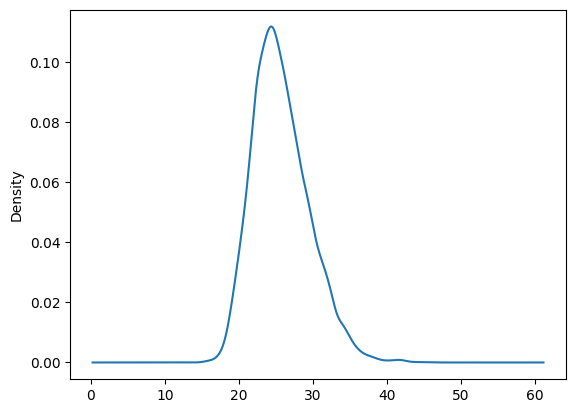

In [56]:
df_baseline['scores'].plot.kde()

<Axes: ylabel='Frequency'>

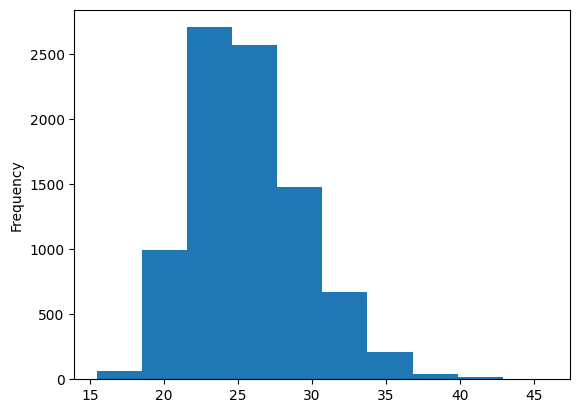

In [57]:
df_baseline['scores'].plot.hist()

##### Optimal BB Stats

In [58]:
df_optimal_mybb = pd.read_csv('Optimal myBB adv obs.csv',
                          header=None)

In [59]:
df_optimal_mybb['scores'] = score(df_optimal_mybb).abs().sum(axis='columns')

In [60]:
df_optimal_mybb['scores'].describe()

count    8759.000000
mean      372.325740
std       187.790013
min        18.101440
25%       236.890920
50%       380.495075
75%       506.265397
max      1046.115776
Name: scores, dtype: float64

<Axes: ylabel='Density'>

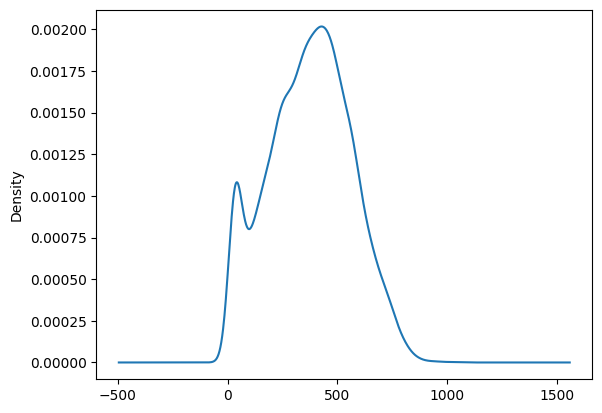

In [61]:
df_optimal_mybb['scores'].plot.kde()

<Axes: ylabel='Frequency'>

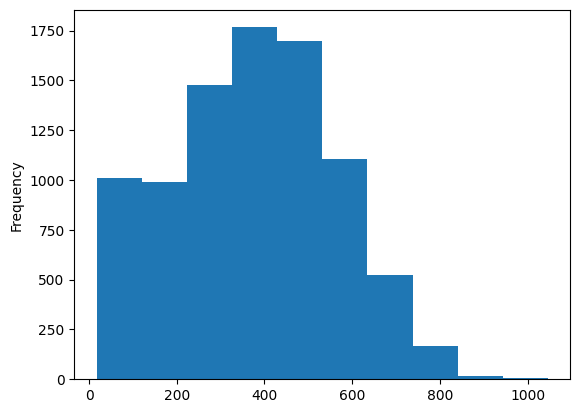

In [62]:
df_optimal_mybb['scores'].plot.hist()

##### ACG Stats

In [63]:
df_acg = pd.read_csv('adv_perturbed_obs.csv',
                          index_col=0)

In [64]:
df_acg['scores'] = score(df_acg).abs().sum(axis='columns')

<Axes: ylabel='Density'>

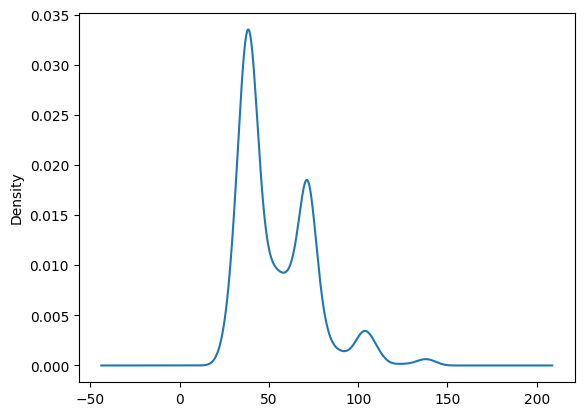

In [65]:
df_acg['scores'].plot.kde()

In [66]:
df_acg['scores'].describe()

count    8759.000000
mean       54.489584
std        21.369896
min        19.302492
25%        37.961534
50%        46.793621
75%        69.834413
max       145.529455
Name: scores, dtype: float64

##### Untargeted BB Stats

In [67]:
df_bb = pd.read_csv('bb results/bb obs.csv',
                    index_col=0)

In [68]:
df_bb['scores'] = score(df_bb).abs().sum(axis='columns')

In [69]:
df_bb['scores'].describe()

count    8759.000000
mean       48.079316
std        40.153437
min        15.423704
25%        29.962958
50%        34.833859
75%        49.968315
max       555.939563
Name: scores, dtype: float64

##### All Together Now

In [70]:
df_scores = pd.concat([df_baseline['scores'],df_optimal_mybb['scores'],df_acg['scores'],df_bb['scores']],
                      axis='columns').dropna()

In [71]:
df_scores.shape

(8759, 4)

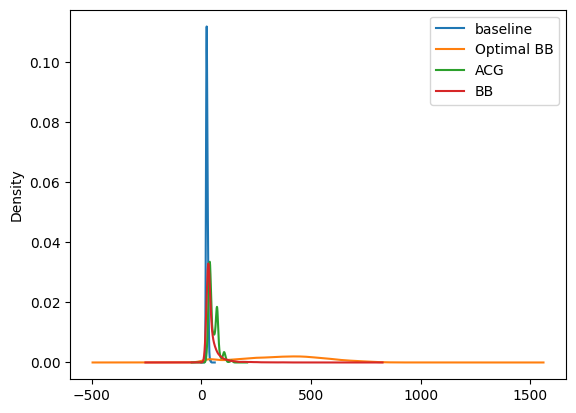

In [72]:
leg = ['baseline','Optimal BB','ACG','BB']
df_scores.plot.kde().legend(leg)

From the graph below, it appears diffcult to separate the baseline and BB distributions with an Z sum threshold without a high FP rate, however it look possible for acg. Optimal BB is way out there

In [73]:
ff.create_distplot([df_baseline['scores'].dropna(),df_optimal_mybb['scores'].dropna(),df_acg['scores'].dropna(),df_bb['scores'].dropna()],
                   leg,
                   #bin_size=0.025,
                   show_rug=False,
                   )

##### for thesis
These grpahs show that with a good estimate of the distrubtion of clean data (mean and std) it's possible to isolate outliers cause by adversarial perturbations. However obtaining this estimate is difficult. It may be possible from historical weather data, and maybe usage, but many factors can affect observations like the price of electricity.

Detection might be facilitated by cross referencing observations from different sites. E.g. does the temperature/solar variation make sense?

Consider correlation between features, like sunlight and temperature considering the time and month

In [74]:
ff.create_distplot([df_baseline['scores'].dropna(),df_acg['scores'].dropna(),df_bb['scores'].dropna()],
                   ['baseline','ACG','BB'],
                   #bin_size=0.025,
                   show_rug=False,
                   )

In [75]:
threshold = 36
print(f'for a theshold of {threshold} comparing acg to the baseline')
print(f'True positive rate: {(df_acg["scores"] > threshold).mean()}')
print(f'False positive rate: {(df_baseline["scores"] > threshold).mean()}')
print(f'False nagative rate: {(df_acg["scores"] < threshold).mean()}')

for a theshold of 36 comparing acg to the baseline
True positive rate: 0.8264642082429501
False positive rate: 0.011074323552917
False nagative rate: 0.1735357917570499


In [76]:
threshold = 40
print(f'for a theshold of {threshold} comparing acg to the baseline')
print(f'True positive rate: {(df_acg["scores"] > threshold).mean()}')
print(f'False positive rate: {(df_baseline["scores"] > threshold).mean()}')
print(f'False nagative rate: {(df_acg["scores"] < threshold).mean()}')

for a theshold of 40 comparing acg to the baseline
True positive rate: 0.6658294325836283
False positive rate: 0.002740038817216577
False nagative rate: 0.33417056741637174


In [77]:
threshold = 36
print(f'for a theshold of {threshold} comparing bb to the baseline')
print(f'True positive rate: {(df_bb["scores"] > threshold).mean()}')
print(f'False positive rate: {(df_baseline["scores"] > threshold).mean()}')
print(f'False nagative rate: {(df_bb["scores"] < threshold).mean()}')

for a theshold of 36 comparing bb to the baseline
True positive rate: 0.4587281653156753
False positive rate: 0.011074323552917
False nagative rate: 0.5412718346843247


Could the median work better than the sum? What about correlations between fetures (will that even work for individual samples)?

What about a windowed mean and std for the z scores, would this detect when adv samples begin? What about cumulative?

Could I test this by starting the perturbations part way through an episode?

In [78]:
acg_mask = np.arange(2000, 2100) #2000 leave some time for the mean and std to converge
X = df_baseline.drop(columns='scores')
X.iloc[acg_mask] = df_acg.iloc[acg_mask].drop(columns='scores')
Y = np.ones(X.shape[0])
Y[acg_mask] = 0

Use the cumulative calculated mean and std to generated z scores for each feature. This simulates how the mean and std could be calculated during implementation

In [79]:
X['scores'] = ((X - X.expanding().mean())/X.expanding().std()).abs().sum(axis='columns') #the std can be 0 which results in a lot of nans for day_typ_cos

In [81]:
X['scores'][X['scores'] == np.inf].index

Int64Index([2, 5, 8, 10, 11, 12, 14, 21], dtype='int64')

In [82]:
X['scores'].replace([np.inf, -np.inf], np.nan, inplace=True)

In [101]:
X['scores'].describe()

count    8751.000000
mean       26.879345
std         4.538271
min         0.000000
25%        23.729208
50%        26.376892
75%        29.492929
max        74.804098
Name: scores, dtype: float64

In [100]:
low = X.index.min()
high = X.index.max()
px.line(X.iloc[low:high,:], x=X.iloc[low:high,:].index, y='scores', color=Y[low:high])

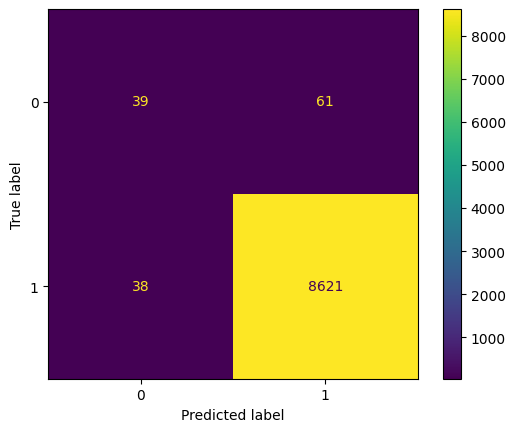

In [119]:
preds = X['scores'].apply(lambda x: 1 if x < 41 else 0)
ConfusionMatrixDisplay(confusion_matrix(Y,preds)).plot()

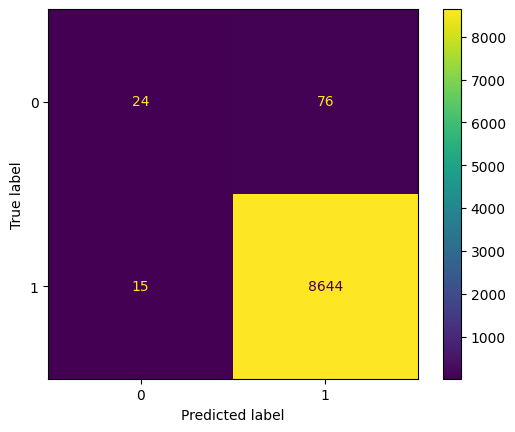

In [128]:
preds = X['scores'].apply(lambda x: 1 if x < 46 else 0)
ConfusionMatrixDisplay(confusion_matrix(Y,preds)).plot()